In [41]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
def f(x):
    return 3*x**2 - 4*x + 5

In [43]:
f(3.0)

20.0

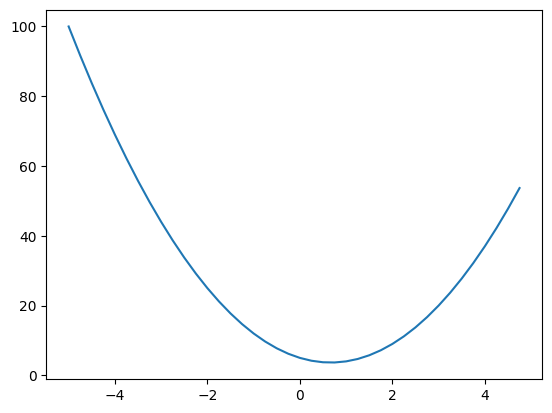

In [44]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [45]:
h = 0.00001
x = 2/3
(f(x + h) - f(x))/h

3.0000002482211127e-05

In [46]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [137]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
    # print format
    def __repr__(self):
        return f"Value(data={self.data})"
    # value + value
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        # backpropagation, chain rule
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    # value * value
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
    # back propagation, chain rule
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    # tanh function
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x) + 1)
        # Value constructor
        out = Value(t, (self, ), 'tanh')
        # back prop, chain rule
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        # topological sort
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            # add to list once all children are added to list, invariant
            topo.append(v)
        build_topo(self)
    
        self.grad = 1.0
        # starting at o
        for node in reversed(topo):
            node._backward()
 

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
#a.__mul__(b).__add__(c)

In [50]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #, node_attr={'rankdir': 'TB'})
    
    nodes, edges = trace(root)    
    for n in nodes:
        uid = str(id(n))
        # for any value in graph, create rectangular record node
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if value is some operation, create a circular op node 
            dot.node(name=uid + n._op, label=n._op)
            # connect this node to it
            dot.edge(uid  + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to op of node n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

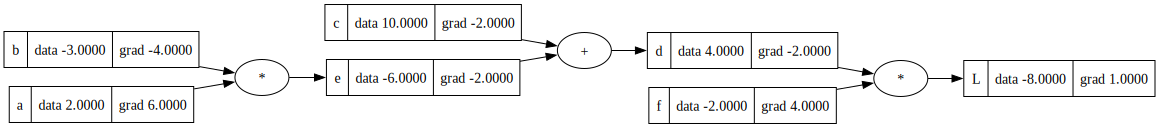

In [92]:
draw_dot(L)

In [91]:
# manual gradient
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
e.grad = -2.0
c.grad = -2.0
b.grad = -4.0
a.grad = 6.0

In [88]:
# manual forward pass, optimized
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)
# de/dL
# da/dL
# da/de * de/dL

-6.586368000000001


In [87]:
# manual gradient check
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

-3.9999999999995595


In [138]:
# ex 2

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

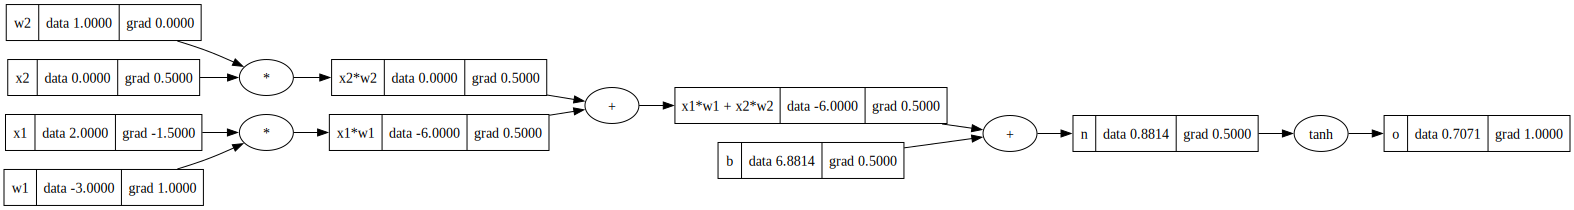

In [141]:
draw_dot(o)

In [113]:
# manual gradient
o.grad = 1.0
n.grad = 0.5
b.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5

# * gradient
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

# o = tanh(n)
# do/dn = 1 - tanh(o)**2
# 1-(o.data**2)

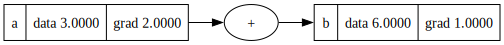

In [144]:
# edge case 1, single node where self = other
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

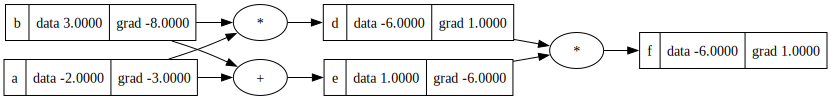

In [145]:
# edge case 2 multivariate case, variables used more than once
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)